In [19]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets
import sklearn.gaussian_process as gp
import time

In [17]:
#define the gaussian process model

def gaussian(df, kernel, title, n_restarts_optimizer=10, alpha=0.1, l = 16):
    start = time.time()
    train_df = df[df.label!='OOD']
    train_y = train_df.label.values
    train_x = train_df.drop(columns = ['label']).values

#     kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(10.0, (1e-3, 1e3))
    model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=n_restarts_optimizer, alpha=alpha, 
                                        normalize_y=True)
    model.fit(train_x, train_y)
    params = model.kernel_.get_params()

    whole_y = df.label.replace('OOD', -1).values
    whole_x = df.drop(columns = ['label']).values
    y_pred, std = model.predict(whole_x, return_std=True)
    
    fig, ax = plt.subplots(1, 2, figsize = (15, 5))
#     plt.figure(figsize=[8,5])
    
    df_new = pd.DataFrame(dict(x=whole_x[:,0], y=whole_x[:,1], label=y_pred))
    sns.scatterplot(data=df_new, x="x", y="y", hue="label", ax = ax[0]);
    
    
    x = np.linspace(-l,l,1000).reshape(-1,1)
    y = np.linspace(-l,l,1000).reshape(-1,1)
    X,Y = np.meshgrid(x,y)
    Z = np.zeros((1000,1000))

    for i in range(1000):
    #     for j in range(1000):
        xy = np.concatenate((X[i].reshape(-1,1), Y[i].reshape(-1,1)), axis = 1)
        y_pred_new, std_new = model.predict(xy, return_std=True)
        Z[i] = std_new

#     ax[1].pcolor(X, Y, Z)
    ax[1].pcolormesh(X, Y, Z, shading='gouraud', vmin=Z.min(), vmax=Z.max())
    ax[1].scatter(df[df.label==0].x, df[df.label==0].y, color = 'blue')
    ax[1].scatter(df[df.label==1].x, df[df.label==1].y, color = 'green')
    ax[1].scatter(df[df.label==2].x, df[df.label==2].y, color = 'red')
    ax[1].scatter(df[df.label=='OOD'].x, df[df.label=='OOD'].y, color = 'yellow')
    ax[0].set_title('{} predictions'.format(title))
    ax[1].set_title('{} uncertainties'.format(title))
#     plt.show()
    print('execution time: {} mins'.format((time.time()-start)/60))
    return model, ax

### 1. Well-Seperated and Linearly-Seperable

In [3]:
# generate 3 classes
X, y = datasets.make_blobs(n_samples=[200,200,200], 
                           centers=[[0, 3], [-3, -3], [3, -3]], 
                           cluster_std=0.9, 
                           n_features=2, 
                           random_state=0)

#### a) ODD-ring

In [4]:
# generate OOD
np.random.seed(0)
r = 6.8 # radius
x1, x2 = [], []
for _ in range(500):
    # random angle
    angle = np.random.uniform(0,2 * np.pi)
    x1.append((r + random.random())*np.cos(angle))
    x2.append(-.5+(r + random.random())*np.sin(angle))

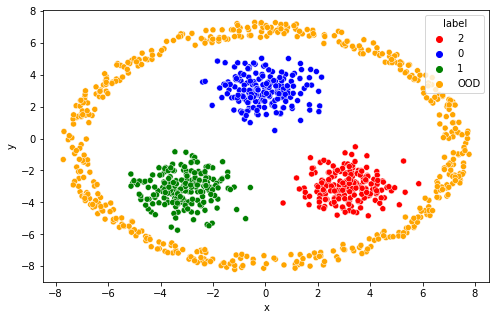

In [5]:
df1a = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
df1a_ood = pd.DataFrame(dict(x=x1, y=x2, label='OOD'))
df1a = df1a.append(df1a_ood, ignore_index=True)

plt.figure(figsize=[8,5])
sns.scatterplot(data=df1a, x="x", y="y", hue="label", palette=["red", "blue", "green", "orange"]);

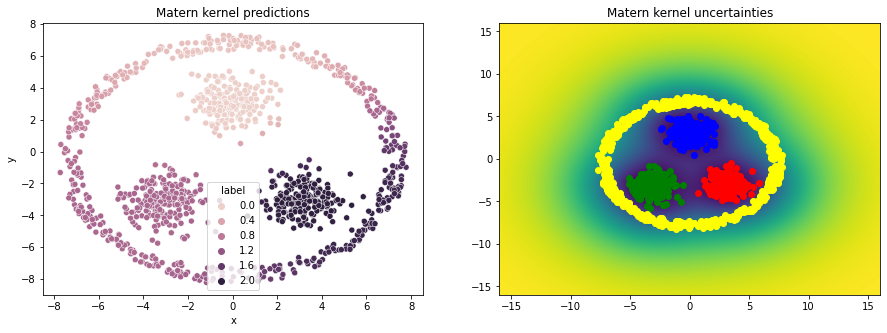

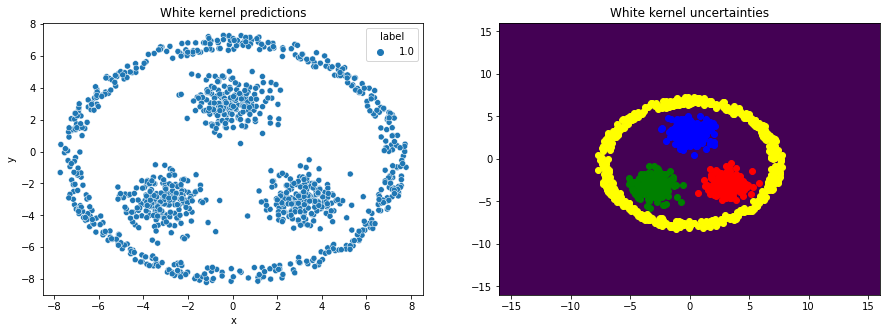

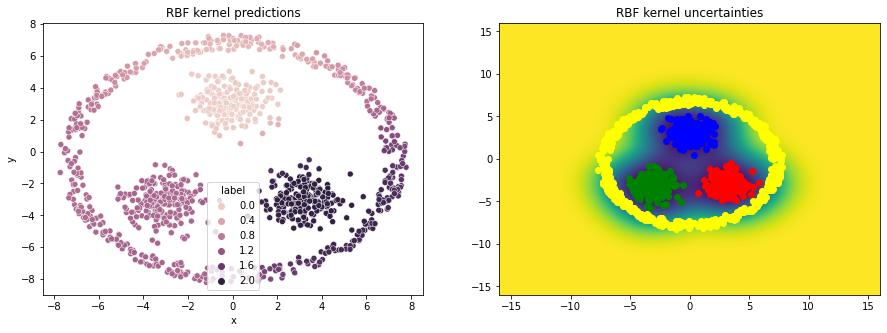

In [15]:
#adjust kernel parameters
kernel1 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.Matern(length_scale=1.0, nu=1.5)
model1a1, ax1 = gaussian(df1a, kernel1, 'Matern kernel')
kernel2 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.WhiteKernel(noise_level=0.5)
model1a2, ax2 = gaussian(df1a, kernel2, 'White kernel')
kernel3 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(1.0, (1e-3, 1e3))
model1a2, ax3 = gaussian(df1a, kernel3, 'RBF kernel')
plt.show()

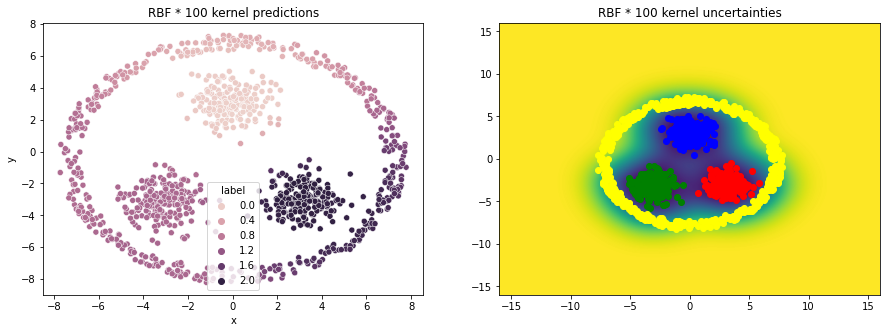

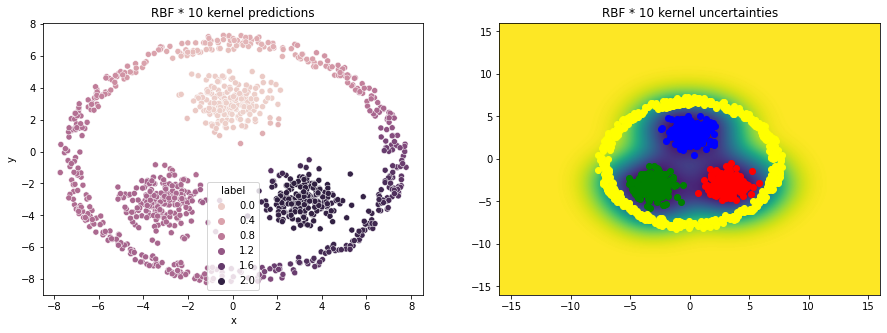

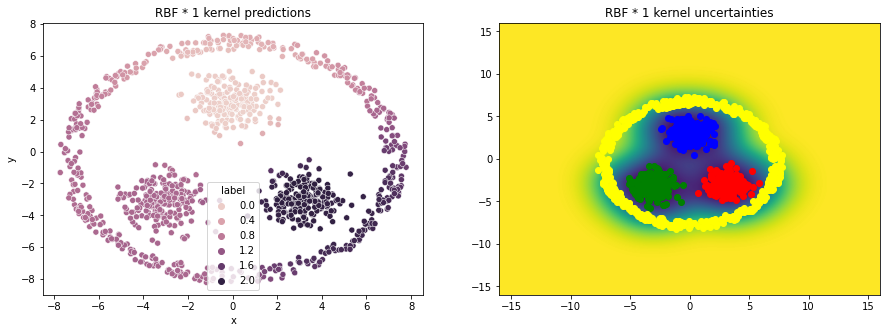

In [16]:
#adjust kernel parameters
kernel1 = gp.kernels.ConstantKernel(100.0, (1e-1, 1e3)) * gp.kernels.RBF(1.0, (1e-3, 1e3))
model1a1, ax1 = gaussian(df1a, kernel1, 'RBF * 100 kernel')
kernel2 = gp.kernels.ConstantKernel(10.0, (1e-1, 1e3)) * gp.kernels.RBF(1.0, (1e-3, 1e3))
model1a2, ax2 = gaussian(df1a, kernel2, 'RBF * 10 kernel')
kernel3 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(1.0, (1e-3, 1e3))
model1a2, ax3 = gaussian(df1a, kernel3, 'RBF * 1 kernel')
plt.show()

execution time: 0.3033496022224426 mins
execution time: 0.33647386233011883 mins
execution time: 0.9479558348655701 mins


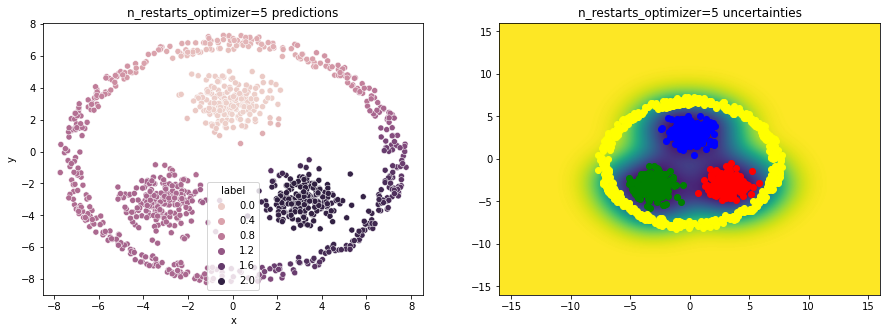

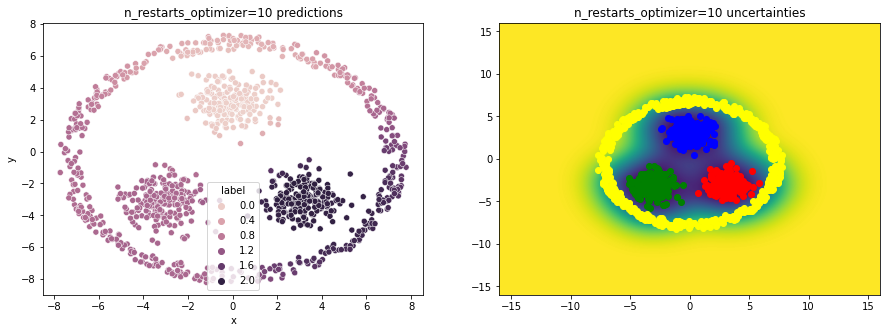

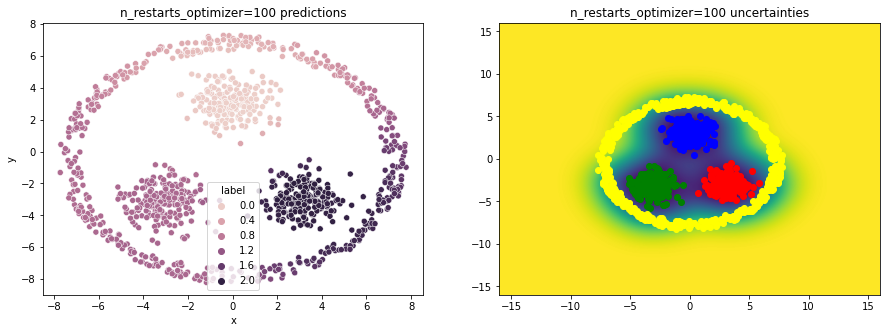

In [22]:
#adjust n_start optimizer parameters
kernel1 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(1.0, (1e-3, 1e3))
model1a1, ax1 = gaussian(df1a, kernel1, 'n_restarts_optimizer=5', n_restarts_optimizer=5)
model1a2, ax2 = gaussian(df1a, kernel1, 'n_restarts_optimizer=10', n_restarts_optimizer=10)
model1a2, ax3 = gaussian(df1a, kernel1, 'n_restarts_optimizer=100', n_restarts_optimizer=100)
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


execution time: 0.31301178137461344 mins
execution time: 0.3298117319742839 mins
execution time: 0.34988951683044434 mins


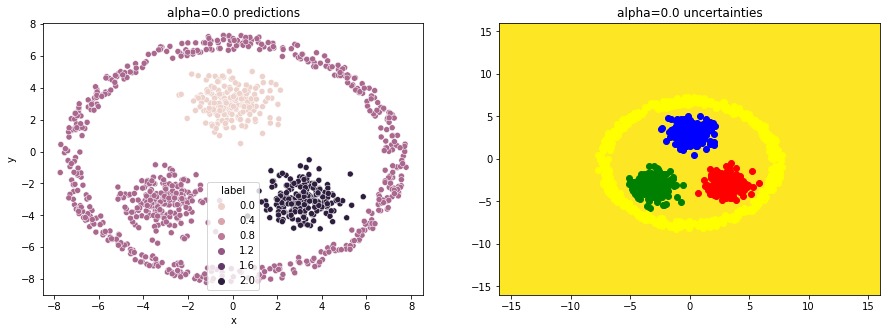

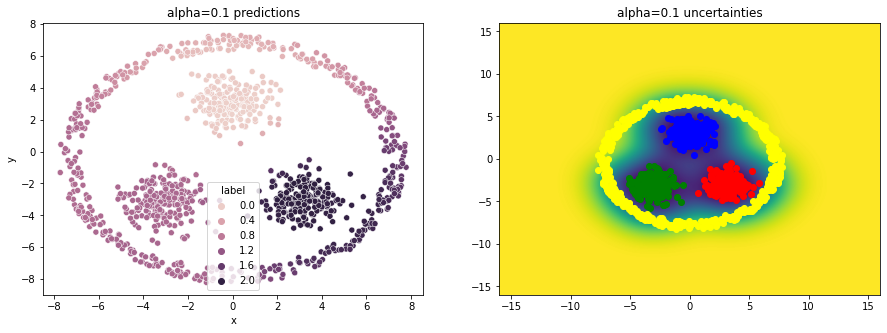

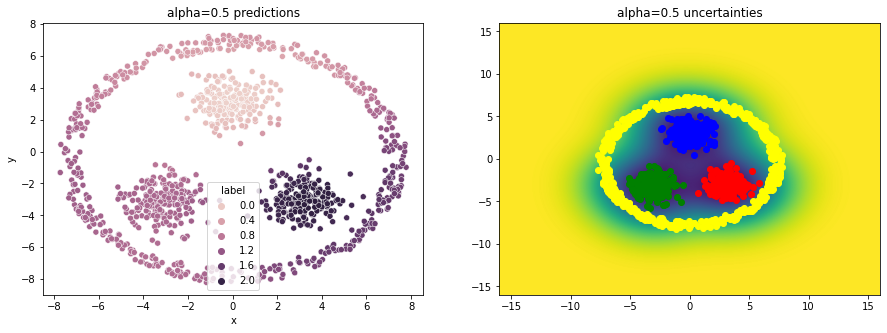

In [23]:
#adjust alpha parameters
kernel1 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(1.0, (1e-3, 1e3))

model1a1, ax1 = gaussian(df1a, kernel1, 'alpha=0.0', alpha=0.0)
model1a2, ax2 = gaussian(df1a, kernel1, 'alpha=0.1', alpha=0.1)
model1a2, ax3 = gaussian(df1a, kernel1, 'alpha=0.5', alpha=0.5)
plt.show()

#### b) OOD-semicircle

In [24]:
# generate OOD
np.random.seed(0)
r = 6 # radius
x1, x2 = [], []
for _ in range(500):
    # random angle
    angle = np.random.uniform(0,np.pi)
    x1.append((r + random.random())*np.cos(angle))
    x2.append((r + random.random())*np.sin(angle))

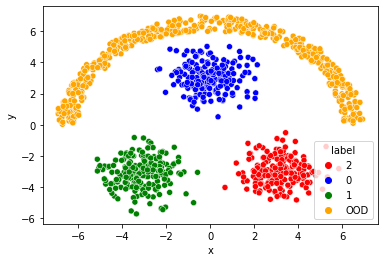

In [25]:
df1b = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
df1b_ood = pd.DataFrame(dict(x=x1, y=x2, label='OOD'))
df1b = df1b.append(df1b_ood, ignore_index=True)

sns.scatterplot(data=df1b, x="x", y="y", hue="label", palette=["red", "blue", "green", "orange"]);

execution time: 0.38170908292134603 mins
execution time: 0.6021908164024353 mins
execution time: 0.3491305192311605 mins


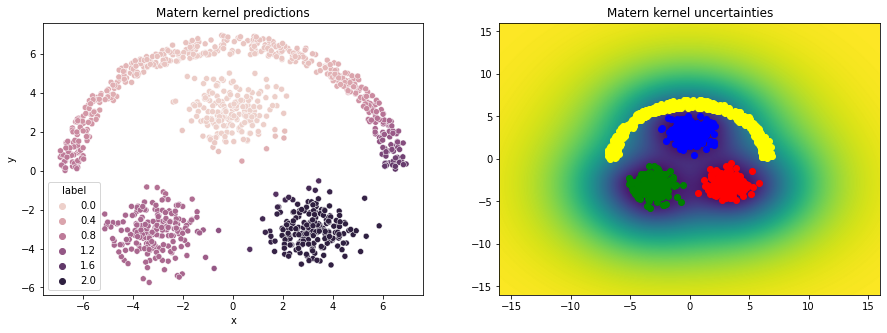

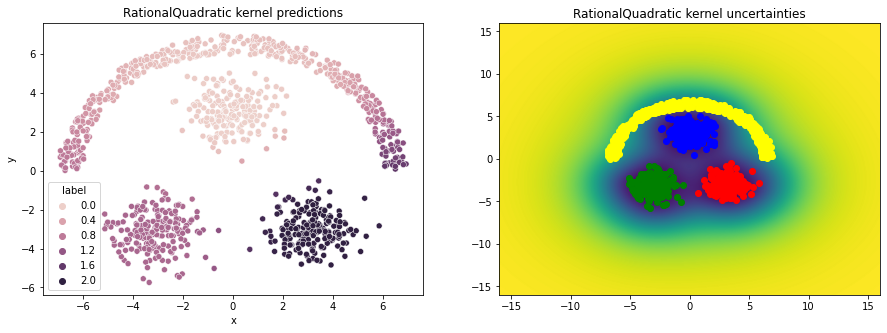

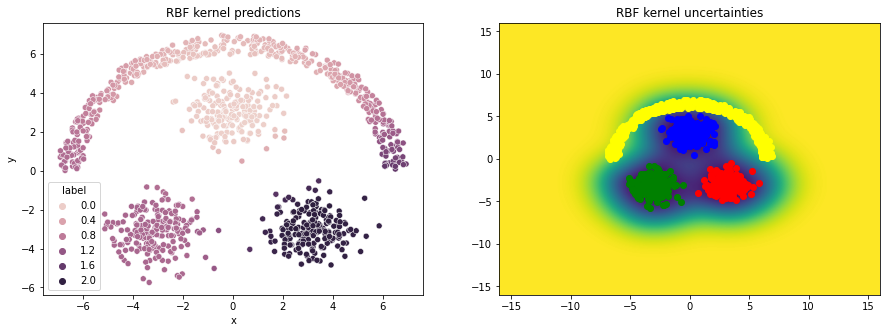

In [27]:
# model1b, ax = gaussian(df1b)

#adjust kernel parameters
kernel1 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.Matern(length_scale=1.0, nu=1.5)
model1b1, ax1 = gaussian(df1b, kernel1, 'Matern kernel')
kernel2 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RationalQuadratic(length_scale=1.0, alpha=1.5)
model1b2, ax2 = gaussian(df1b, kernel2, 'RationalQuadratic kernel')
kernel3 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(1.0, (1e-3, 1e3))
model1b2, ax3 = gaussian(df1b, kernel3, 'RBF kernel')
plt.show()

### 2. Well-Seperated and Linearly-Seperable, but clusters are far away from each other

In [28]:
# generate 3 classes
X, y = datasets.make_blobs(n_samples=[200,200,200], 
                           centers=[[0, 6], [-6, -6], [6, -6]], 
                           cluster_std=1, 
                           n_features=2, 
                           random_state=0)

#### a) one ODD boundary

In [29]:
# generate OOD
np.random.seed(0)
r = 11.5 # radius
x1, x2 = [], []
for _ in range(500):
    # random angle
    angle = np.random.uniform(0,2 * np.pi)
    x1.append((r + random.random())*np.cos(angle))
    x2.append(-1+(r + random.random())*np.sin(angle))

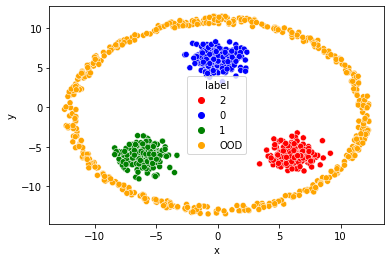

In [30]:
df2a = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
df2a_ood = pd.DataFrame(dict(x=x1, y=x2, label='OOD'))
df2a = df2a.append(df2a_ood, ignore_index=True)

sns.scatterplot(data=df2a, x="x", y="y", hue="label", palette=["red", "blue", "green", "orange"]);

execution time: 0.3914800842603048 mins
execution time: 0.7286614815394084 mins
execution time: 0.3829574982325236 mins


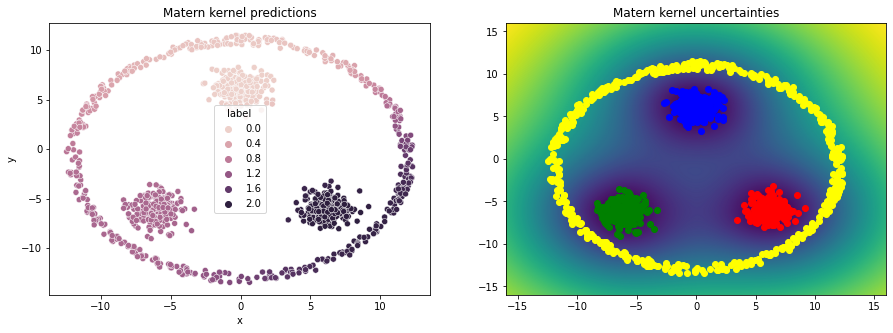

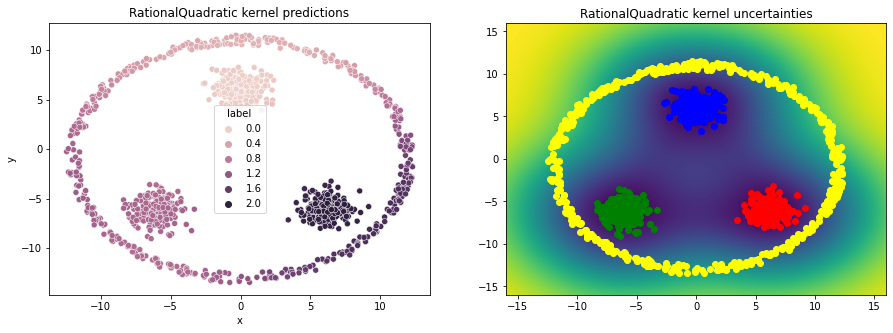

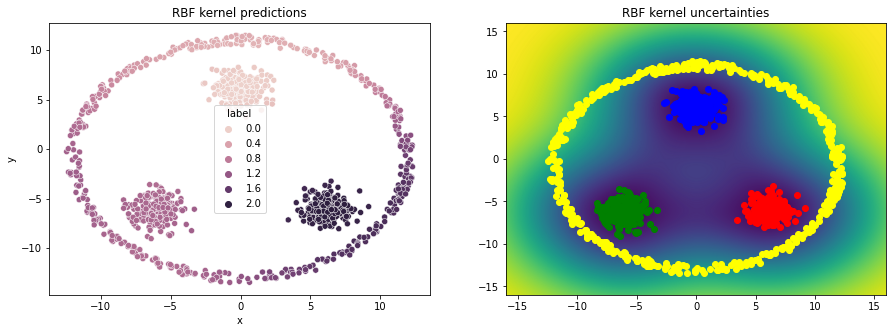

In [31]:
# model2a = gaussian(df2a)

# model1b, ax = gaussian(df1b)

#adjust kernel parameters
kernel1 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.Matern(length_scale=1.0, nu=1.5)
model2a1, ax1 = gaussian(df2a, kernel1, 'Matern kernel')
kernel2 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RationalQuadratic(length_scale=1.0, alpha=1.5)
model2a2, ax2 = gaussian(df2a, kernel2, 'RationalQuadratic kernel')
kernel3 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(1.0, (1e-3, 1e3))
model2a3, ax3 = gaussian(df2a, kernel3, 'RBF kernel')
plt.show()

#### b) three ODD boundary

In [32]:
# generate OOD
np.random.seed(42)
r = 3.5 # radius
cx1, cx2, cx3 = 0, -6, 6
cy1, cy2, cy3 = 6, -6, -6
x1, x2 = [], []
for _ in range(500//3):
    # random angle
    angle = np.random.uniform(0,2 * np.pi)
    x1.append(cx1 + (r + random.random())*np.cos(angle))
    x1.append(cx2 + (r + random.random())*np.cos(angle))
    x1.append(cx3 + (r + random.random())*np.cos(angle))
    x2.append(cy1 + (r + random.random())*np.sin(angle))
    x2.append(cy2 + (r + random.random())*np.sin(angle))
    x2.append(cy3 + (r + random.random())*np.sin(angle))

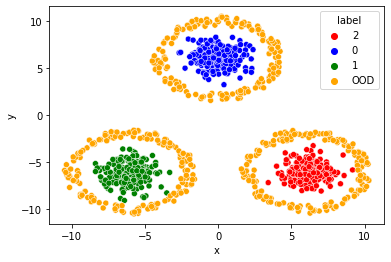

In [33]:
df2b = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
df2b_ood = pd.DataFrame(dict(x=x1, y=x2, label='OOD'))
df2b = df2b.append(df2b_ood, ignore_index=True)

sns.scatterplot(data=df2b, x="x", y="y", hue="label", palette=["red", "blue", "green", "orange"]);

execution time: 0.36105974912643435 mins
execution time: 0.7159509340922038 mins
execution time: 0.3517223000526428 mins


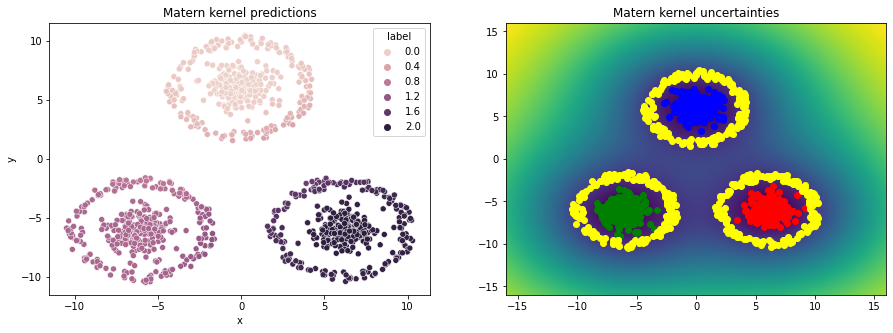

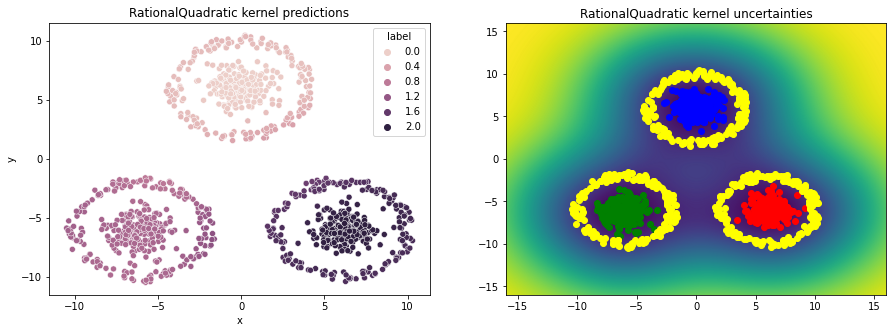

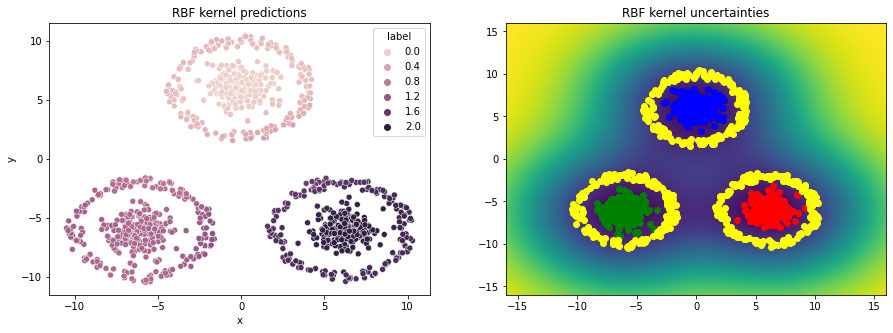

In [34]:
# model2b = gaussian(df2b)

# model1b, ax = gaussian(df1b)

#adjust kernel parameters
kernel1 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.Matern(length_scale=1.0, nu=1.5)
model2b1, ax1 = gaussian(df2b, kernel1, 'Matern kernel')
kernel2 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RationalQuadratic(length_scale=1.0, alpha=1.5)
model2b2, ax2 = gaussian(df2b, kernel2, 'RationalQuadratic kernel')
kernel3 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(1.0, (1e-3, 1e3))
model2b2, ax3 = gaussian(df2b, kernel3, 'RBF kernel')
plt.show()

### 3. Not Well-Seperated

In [35]:
# generate 3 classes
X, y = datasets.make_blobs(n_samples=[200,200,200], 
                           centers=[[0, 1], [-1, -1], [1, -1]], 
                           cluster_std=1, 
                           n_features=2, 
                           random_state=0)

In [36]:
# generate OOD
np.random.seed(42)
r = 4.5 # radius
x1, x2 = [], []
for _ in range(500):
    # random angle
    angle = np.random.uniform(0,2 * np.pi)
    x1.append((r + random.random())*np.cos(angle))
    x2.append((r + random.random())*np.sin(angle))

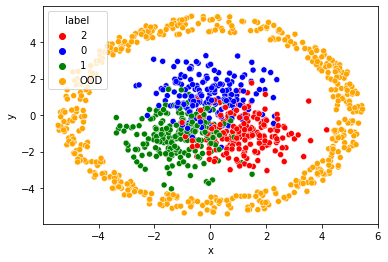

In [37]:
df3 = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
df3_ood = pd.DataFrame(dict(x=x1, y=x2, label='OOD'))
df3 = df3.append(df3_ood, ignore_index=True)

sns.scatterplot(data=df3, x="x", y="y", hue="label", palette=["red", "blue", "green", "orange"]);

execution time: 0.3785403847694397 mins
execution time: 0.7242049654324849 mins
execution time: 0.37920191685358684 mins


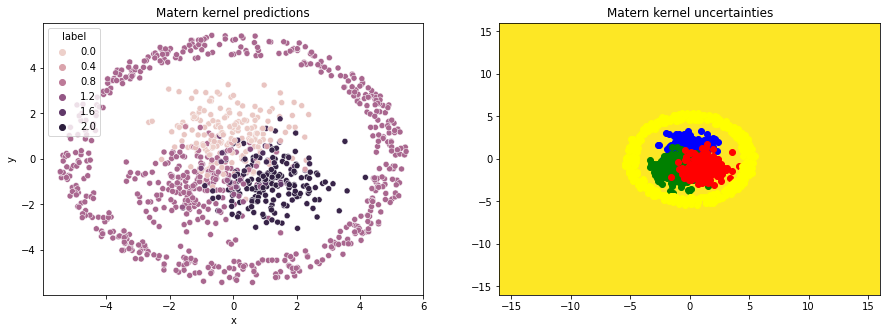

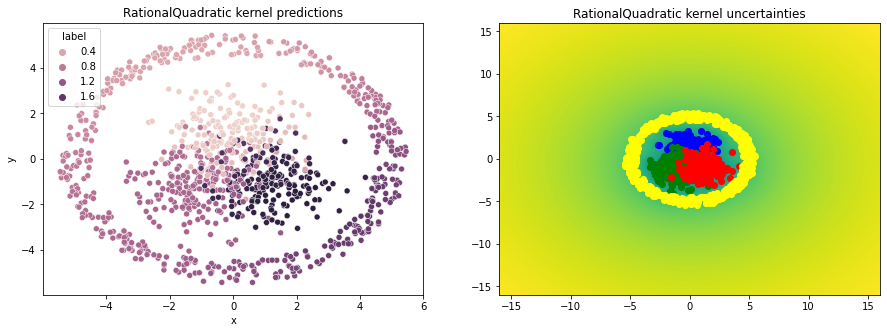

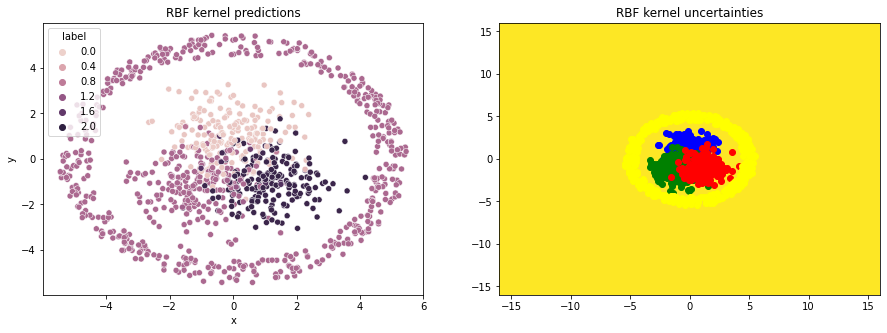

In [39]:
# model3 = gaussian(df3, l = 5)

# model1b, ax = gaussian(df1b)

#adjust kernel parameters
kernel1 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.Matern(length_scale=1.0, nu=1.5)
model31, ax1 = gaussian(df3, kernel1, 'Matern kernel')
kernel2 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RationalQuadratic(length_scale=1.0, alpha=1.5)
model32, ax2 = gaussian(df3, kernel2, 'RationalQuadratic kernel')
kernel3 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(1.0, (1e-3, 1e3))
model32, ax3 = gaussian(df3, kernel3, 'RBF kernel')
plt.show()

In [ ]:
#try different kernel parameters and kernels
#generalize (accuracy)
#also use OOD?

### 4. Well-Seperated by non-linear boundary

In [40]:
X, y = datasets.make_moons(n_samples=600, shuffle=True, noise=0.1, random_state=0)

In [41]:
# generate OOD
np.random.seed(0)
r = 2 # radius
x1, x2 = [], []
for _ in range(500):
    # random angle
    angle = np.random.uniform(0,2 * np.pi)
    x1.append(.5+(r + random.random())*np.cos(angle))
    x2.append(.3+(r + random.random())/1.5*np.sin(angle))

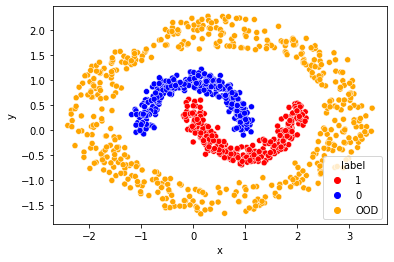

In [42]:
df1a = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
df1a_ood = pd.DataFrame(dict(x=x1, y=x2, label='OOD'))
df1a = df1a.append(df1a_ood, ignore_index=True)

sns.scatterplot(data=df1a, x="x", y="y", hue="label", palette=["red", "blue", "orange"]);

execution time: 0.4028191486994425 mins
execution time: 0.631309966246287 mins
execution time: 1.0429472963015238 mins


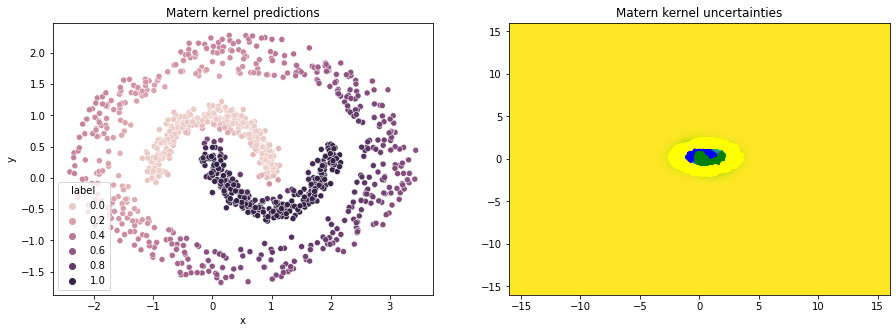

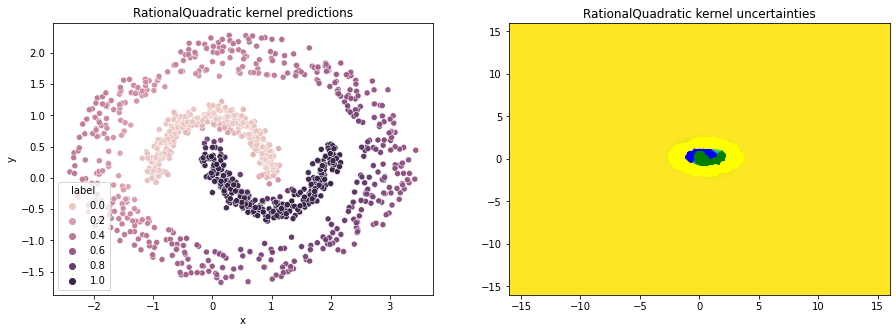

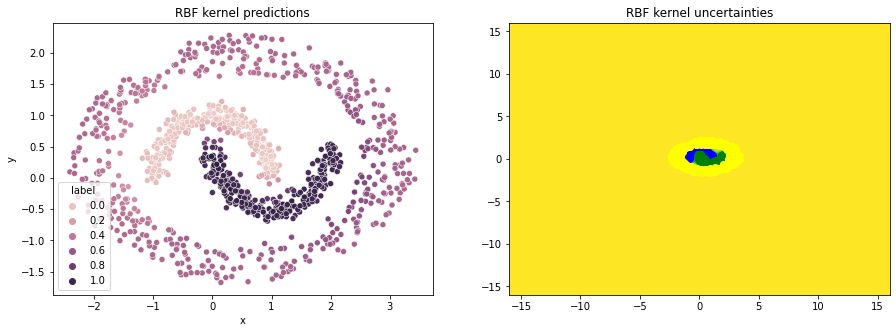

In [43]:
# model4 = gaussian(df1a, l = 5)

# model1b, ax = gaussian(df1b)

#adjust kernel parameters
kernel1 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.Matern(length_scale=1.0, nu=1.5)
model41, ax1 = gaussian(df1a, kernel1, 'Matern kernel')
kernel2 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RationalQuadratic(length_scale=1.0, alpha=1.5)
model42, ax2 = gaussian(df1a, kernel2, 'RationalQuadratic kernel')
kernel3 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(1.0, (1e-3, 1e3))
model42, ax3 = gaussian(df1a, kernel3, 'RBF kernel')
plt.show()